PMT Pulse analysis
=======================
A partire dal tutorial: [PMT Pulse analysis](https://straxen.readthedocs.io/en/latest/tutorials/pulse_analysis.html)

Lavori di Alvaro: [notes by Alvaro](https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:aaloya&s%5B%5D=notes&s%5B%5D=by&s%5B%5D=alvaro)

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

from scipy import stats
import strax
import straxen
from multihist import Histdd, Hist1d

# Print out exactly what versions we are using, for reference / troubleshooting:
import sys
import os.path as osp

In [3]:
st = straxen.contexts.xenonnt_online()

In [4]:
#dsets = st.select_runs(available='raw_records', include_tags='sciencerun1', run_mode='background_stable')
#run_id = dsets.name.min()
runs = st.select_runs(available='raw_records')

Checking data availability: 100%|██████████| 2/2 [01:59<00:00, 59.98s/it]


In [5]:
runs.head()

,name,number,mode,start,end,tags,livetime,tags.name,peak_basics_available,raw_records_available
842,008000,8000,xenonnt_selftrigger_commissioning_lowe,2020-05-27 04:21:10.029,2020-05-27 05:21:10.960,,01:00:00.931000,NaN,False,True
843,008001,8001,xenonnt_selftrigger_commissioning_lowe,2020-05-27 05:21:41.092,2020-05-27 06:21:42.676,,01:00:01.584000,NaN,False,True
844,008002,8002,xenonnt_selftrigger_commissioning_lowe,2020-05-27 06:22:11.800,2020-05-27 07:22:13.166,,01:00:01.366000,NaN,False,True
845,008003,8003,xenonnt_selftrigger_commissioning_lowe,2020-05-27 07:22:40.289,2020-05-27 08:22:40.824,,01:00:00.535000,NaN,False,True
846,008004,8004,xenonnt_selftrigger_commissioning_lowe,2020-05-27 08:23:09.960,2020-05-27 09:23:11.994,,01:00:02.034000,NaN,True,True


In [6]:
#run_id = '007208'
run_id = '008000'

Questo run dura un'ora e non si possono caricare tutte le raw waveform data, prendiamo i primi 30 secondi:

RAW RECORDS
======================
Selection dei **raw records**, che sono presi in input del plugin pulse_processing.

In [7]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this is supported)
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


Plot dei primi records del run
---------------------------

Si selezionano i record soltanto per i primi 30 secondi del run.

In [8]:
rr = st.get_array(run_id, 'raw_records', seconds_range=(0, 30))
#rr_he = st.get_array(run_id, 'raw_records_he', seconds_range=(0, 2))

In [20]:
def plotRecords(rr,nn,llim,rlim,dlim,ulim,pleg=False):
    dt = rr['dt'][0]
    print('run',run_id,'total number of records',rr['data'].shape[0])
    dts = np.arange(0,rr['data'].shape[1]*dt,dt)
    plt.figure(figsize=(20,5))
    for i in range(nn):
        plt.plot(dts,rr['data'][i],label=f"PMT n. {rr['channel'][i]}")
    if pleg: plt.legend()
    plt.xlabel("time (ns)", ha='right', x=1)
    plt.ylabel(f"ADC", ha='right', y=1)
    if rlim is not 0: plt.xlim(llim,rlim)
    if ulim is not 0: plt.ylim(dlim,ulim)

run 008000 total number of records 5106883


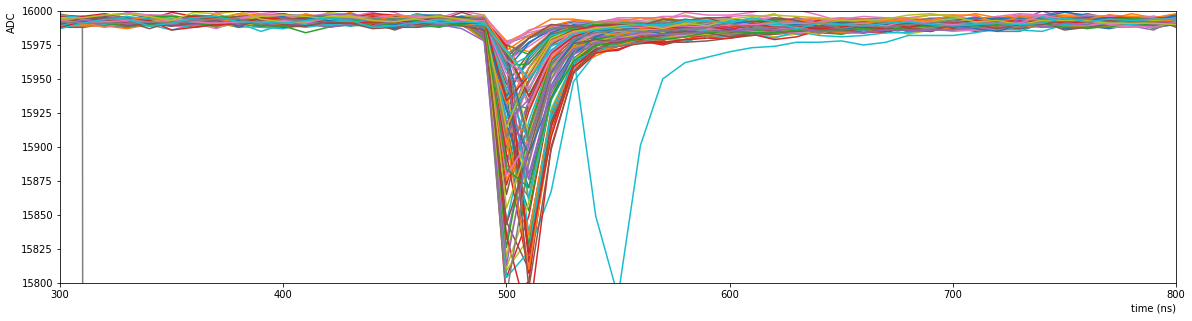

In [9]:
plotRecords(rr,100,300,800,15800,16000)

run 008000 total number of records 5106883


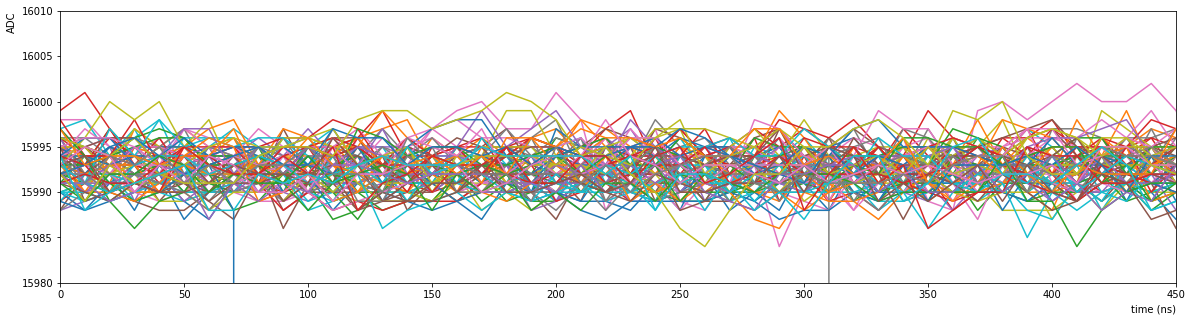

In [10]:
plotRecords(rr,100,0,450,15980,16010)

Sottrazione della baseline
------------------------------

run 008000 total number of records 5106883


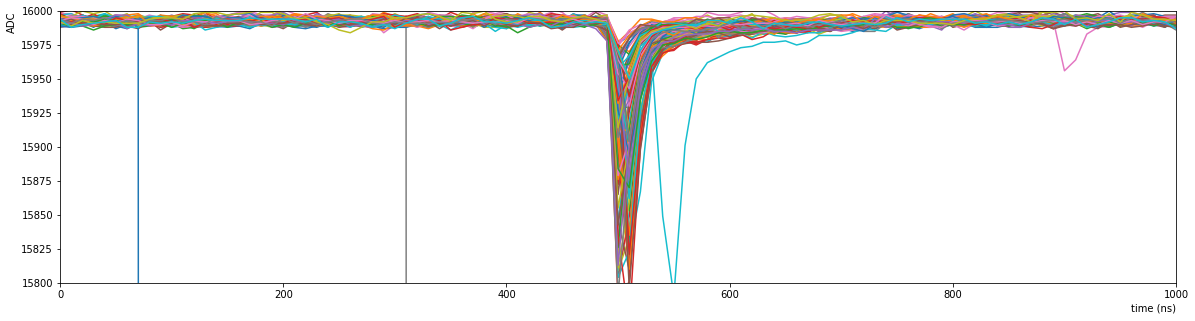

In [11]:
rr0 = strax.raw_to_records(rr)
strax.baseline(rr0)
plotRecords(rr,100,0,1000,15800,16000)

run 008000 total number of records 5106883


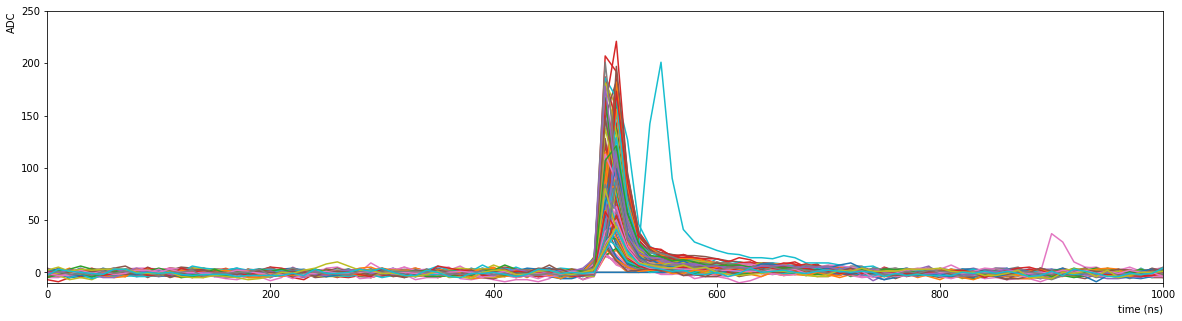

In [12]:
plotRecords(rr0,100,0,1000,-10,250)

Selezione di record e studio del noise per i primi PMT
-----------------------------------

In [17]:
def plotPMT(rr,id):
    #rrs = rr['data'][(rr['channel'] == id) & (rr['data'].min(1)>1.58e4) & (rr['record_i']==0)] #before baseline substraction
    #rrs = rr['data'][(rr['channel'] == id) & (rr['data'].max(1)<10)]# & (rr['record_i']==0)] #before baseline substraction
    rrs = rr['data'][(rr['channel'] == id) & (rr['record_i']==0)
                     & (rr['data'].max(1)<250) & (rr['data'].min(1)>-20)
                     & (rr['data'].argmax(1)<55) & (rr['data'].argmin(1)>45)]
    nev, rsize = rrs.shape[0], rrs.shape[1]
    print('Total number of events:',nev,'length of pulses:',rsize)
    if nev < 100: return
    dt = rr['dt'][0]
    dts = np.arange(0,rr['data'].shape[1]*dt,dt)
    plt.figure(1,figsize=(20,5))
    for i in range(1):
        plt.plot(dts,rrs[i])
    #plt.plot(dts,rrs[i],label=f"{rr['channel'][i]} L={rr['pulse_length'][i]}")
    plt.title(f'raw records')
    #plt.legend()
    plt.xlabel("time (ns)", ha='right', x=1)
    plt.ylabel(f"ADC", ha='right', y=1)
    
    bsize = 45
    bls = np.zeros([nev,bsize])
    for i in range(nev):
        for j in range(bsize):
            bls[i][j] = rrs[i][j]
    plt.figure(2,figsize=(20,5))
    for i in range(1):
        plt.plot(dts[:bsize],bls[i])
    #plt.plot(dts[:bsize],bls[i],label=f"{rr['channel'][i]} L={rr['pulse_length'][i]}")
    plt.title(f'raw records')
    #plt.legend()
    plt.xlabel("time (ns)", ha='right', x=1)
    plt.ylabel(f"ADC", ha='right', y=1)
        
    sampling_rate = 1/(dts[1]-dts[0])*1000
    for i in range(nev):
        fft = np.fft.rfft(bls[i][:])
        abs_fft = np.abs(fft)
        if i is 0: power_spectrum = np.square(abs_fft)
        else: power_spectrum += np.square(abs_fft)
    power_spectrum /= nev
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    plt.figure(3,figsize=(20,5))
    plt.plot(frequency[1:], power_spectrum[1:],label=f"PMT n.{id}")
    plt.title('Power Spectral Density')
    plt.legend()
    #plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("frequency (MHz)", ha='right', x=1)
    plt.ylabel(f"power spectral density", ha='right', y=1)
    
    #import scipy.signal as signal
    ref = bls.mean(axis=0)
    offset = np.mean(ref[:])
    bl = np.zeros([nev,bsize])
    for i in range(nev):
        bl[i] = bls[i][0:bsize]-np.mean(bls[i][0:bsize])
    noise_matr =  np.matmul(bl.transpose(), bl)/nev
    #noise_matr = signal.convolve2d(noise_matr,np.identity(bsize-fsize+1), boundary='symm', mode='valid')/(bsize-fsize+1)
    
    fig, ax = plt.subplots()
    plt.title(f'PMT n. {id}')
    plt.imshow(noise_matr, cmap='viridis',origin='lower')
    plt.colorbar()

Total number of events: 1045 length of pulses: 110


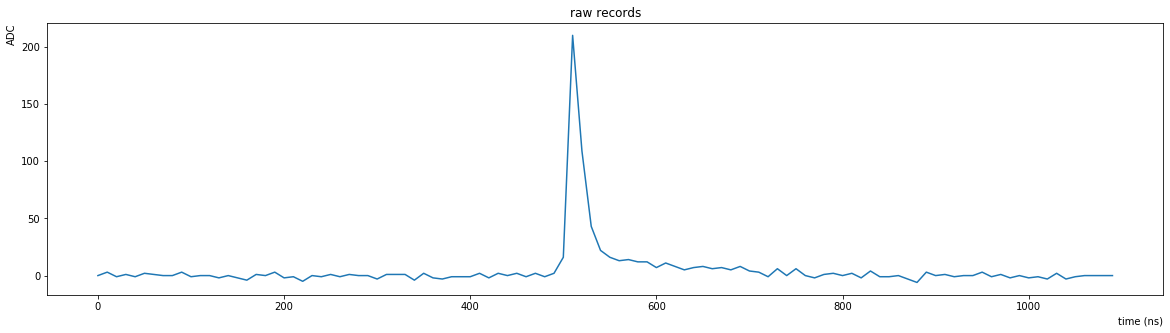

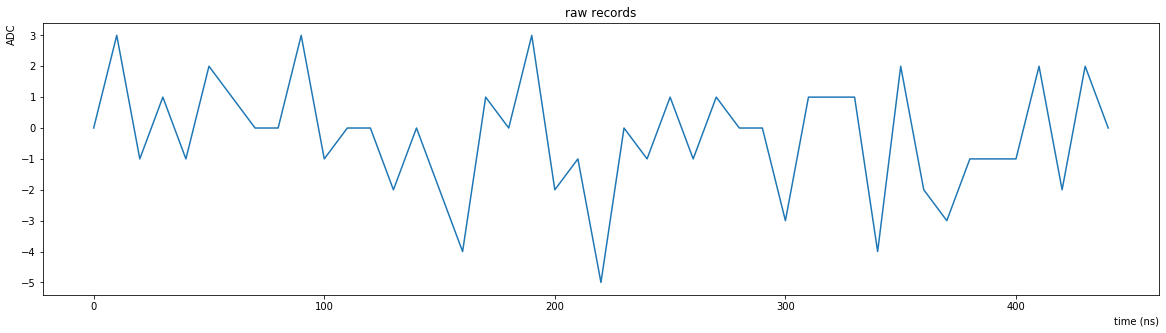

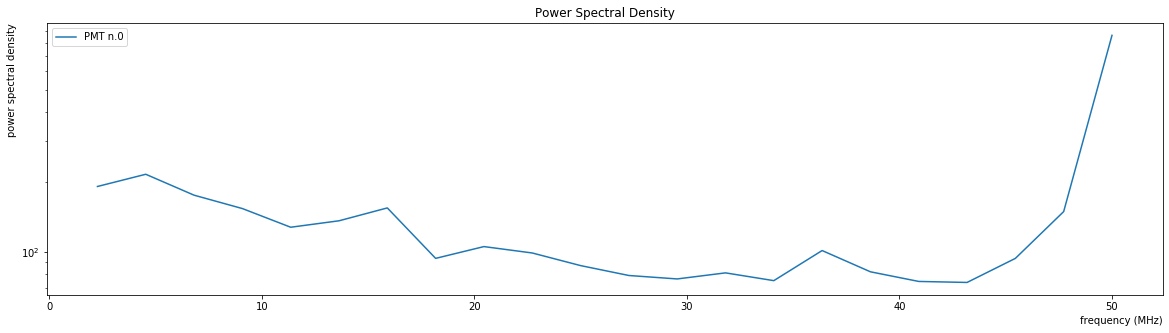

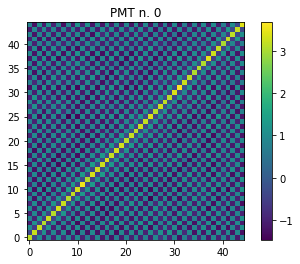

In [16]:
for i in range(1):
    plotPMT(rr0,i)

Total number of events: 1045 length of pulses: 110


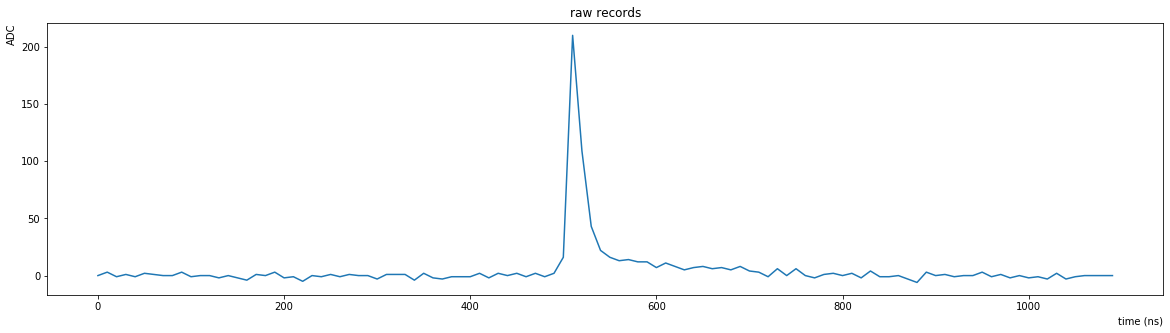

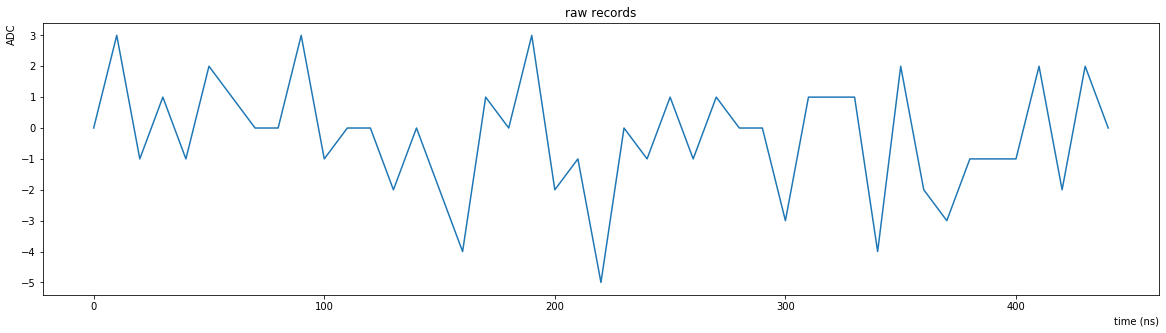

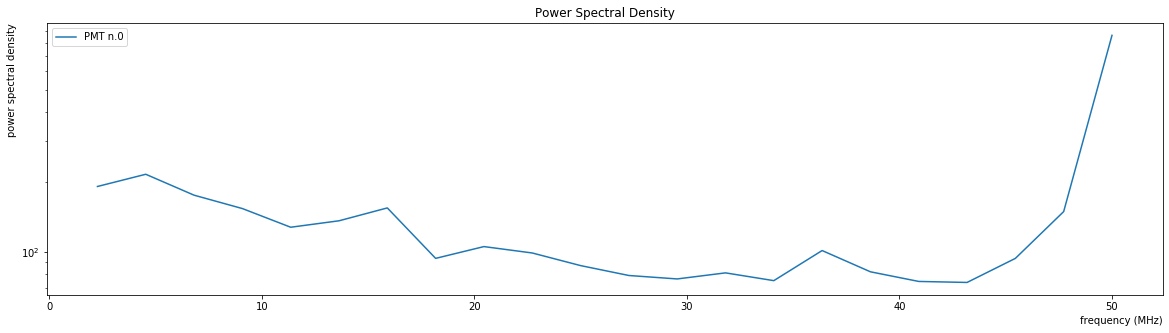

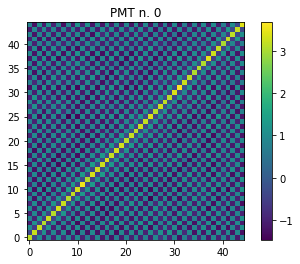

In [17]:
strax.integrate(rr0)
for i in range(1):
    plotPMT(rr0,i)

In [42]:
r = st.get_array(run_id, 'raw_records', seconds_range=(0, 1))
r = strax.raw_to_records(r)
strax.baseline(r)
strax.integrate(r)

run 008000 total number of records 170111


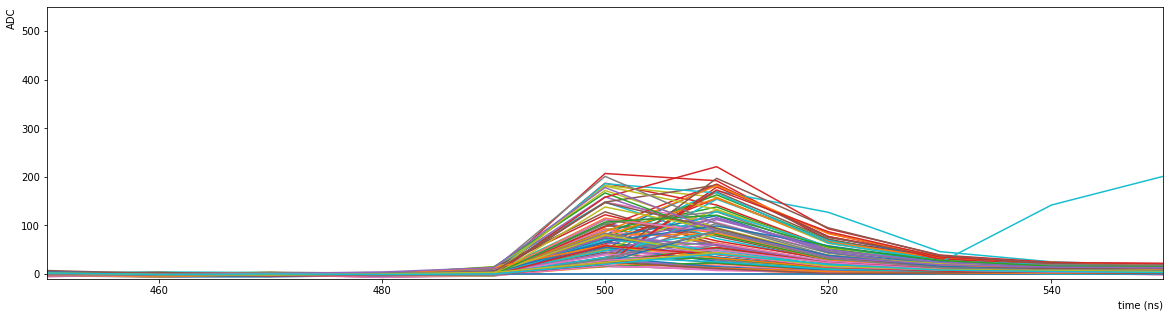

In [43]:
plotRecords(r,100,450,550,-10,550)

run 008000 total number of records 170111


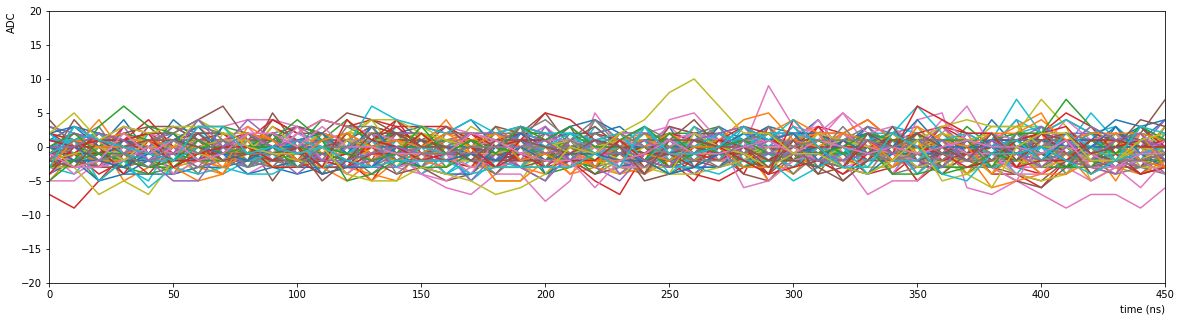

In [44]:
plotRecords(r,100,0,450,-20,20)

In [45]:
pmt_pulse_filter=(0.012, -0.119, 2.435, -1.271, 0.357, -0.174, -0., -0.036, -0.028,
                  -0.019, -0.025, -0.013, -0.03, -0.039, -0.005, -0.019, -0.012, -0.015,
                  -0.029, 0.024, -0.007, 0.007, -0.001, 0.005, -0.002, 0.004, -0.002)
strax.filter_records(r, np.array(pmt_pulse_filter))

run 008000 total number of records 170111


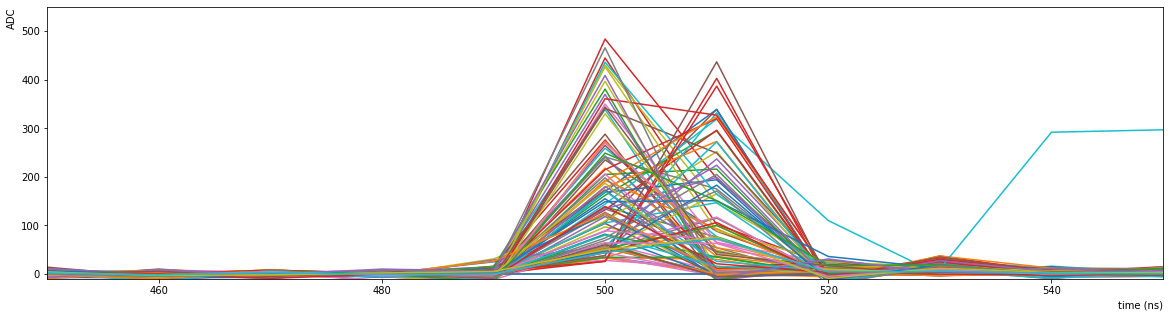

In [46]:
plotRecords(r,100,450,550,-10,550)

run 008000 total number of records 170111


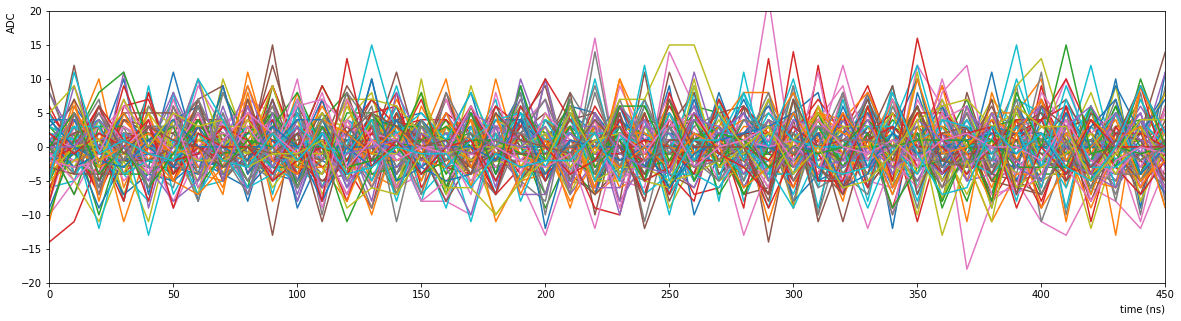

In [38]:
plotRecords(r,100,0,450,-20,20)